[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap03/cap03-main.ipynb)

# Capítulo 4 - Do Monte Carlo ao Q-Learning


Aqui, veremos dois algoritmos de tipos distintos para o problema de *controle* da aprendizagem por reforço -- ou seja, o problema de aprender a política ótima.

O principal que eles têm em comum, é o fato de que **eles se baseiam na função de valor da ação `Q(s,a)`**. Esta função é calculada e usada durante a execução de ambos os algoritmos.

Relembrando, o $Q(s,a)$ ele é o valor médio das recompensas parciais a partir do par $(s,a)$:

$$Q(s,a) = E[G_t | S_t=s, A_t=a]$$

De maneira informa, ele responde a esta pergunta:

*Quando estava no estado* **s** *e fez a ação* **a** *, qual o retorno esperado (se continuar seguindo a política no restante do episódio)?*

Vamos ver como usar esta informação para fazer a escolha de boas ações!

In [6]:
from IPython.display import clear_output
import sys

if 'google.colab' in sys.modules:
    !pip install gym==0.23.1
    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")
    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

In [2]:
import gym
import numpy as np

from util.plot import plot_result
from util.experiments import test_greedy_Q_policy

In [3]:
# vamos focar nesses três ambientes por serem mais simples
# ver mais em: https://www.gymlibrary.dev/
#env = gym.make("Taxi-v3")
#env = gym.make("FrozenLake-v1")
env = gym.make("Blackjack-v1")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 1 - Algoritmo (de Controle) de Monte Carlo - Versão 1

Este algoritmo roda vários episódios, fazendo estes passos a cada episódio:

1. Gera a **trajetória** completa (sequência de estados/observações, ações e recompensas) do episódio:

  $S_0 \rightarrow A_0 \rightarrow R_1 \rightarrow S_1 \rightarrow A_1 \rightarrow R_2 \rightarrow S_2 \rightarrow \cdots S_{n-1} \rightarrow A_{n-1} \rightarrow R_T \rightarrow S_T$

1. Para escolher a ação $a$, a ser realizada em um estado $s$, ele usa a tabela $Q(s,a)$ com alguma estratégia de exploração -- vamos usar $\epsilon$-greedy. Assim, ele escolhe dessa forma:
   - com probabilidade $\epsilon$, ele escolhe uma ação $a$ qualquer
   - com probabilidade $1-\epsilon$, ele escolhe a melhor ação, ou seja, $\max_a{Q(s,a)}$

1. Ao fim do episódio, para cada para intermediário ($S_t$, $A_t$) da trajetória, ele:
   - calcula o retorno parcial $G_t$.
   - usa $G_t$ para atualizar $Q(S_t, A_t)$


In [9]:
# Esta é a política. Neste caso, escolhe uma ação com base nos valores
# da tabela Q, usando uma estratégia epsilon-greedy.
def choose_action_1(Q, state, num_actions, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(0, num_actions)
    else:
        return np.argmax(Q[state])   # alt. para aleatorizar empates: np.random.choice(np.where(b == bmax)[0])


# Algoritmo Monte-Carlo de Controle, variante "toda-visita".
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_montecarlo1(env, episodes, gamma=0.95, epsilon=0.1, render=False):
    num_actions = env.action_space.n

    # dicionário com todos os retornos descontados, para cada par (estado,ação)
    returns_history = dict()

    # inicializa a tabela Q toda com zero,
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-discontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0
        ep_trajectory = []

        state = env.reset()

        # [1] Executa um episódio completo, salvando a trajetória
        while not done:
            # exibe/renderiza os passos no ambiente, durante 1 episódio a cada mil e também nos últimos 5 episódios
            if render and (i >= (episodes - 5) or (i+1) % 1000 == 0):
                env.render()

            # [2] Escolhe a próxima ação -- usa epsilon-greedy
            action = choose_action_1(Q, state, num_actions, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, done, _ = env.step(action)

            # adiciona a tripla que representa este passo
            ep_trajectory.append( (state, action, reward) )

            sum_rewards += reward
            state = next_state

        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if (i+1) % 100 == 0:
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

        # [3] Calcula os retornos parciais e atualiza Q
        Gt = 0
        for (s, a, r) in reversed(ep_trajectory):
            Gt = r + gamma*Gt

            if returns_history.get((s,a)) is None:
                returns_history[s,a] = [ Gt ]
            else:
                returns_history[s,a].append(Gt)

            # média entre todas as ocorrências de (s,a) encontradas nos episódios
            Q[s,a] = np.mean(returns_history[s,a]) # LENTO! -> vamos melhorar

    return sum_rewards_per_ep, Q


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 100 Average Reward (last 100): -459.920
Episode 200 Average Reward (last 100): -701.320
Episode 300 Average Reward (last 100): -435.820
Episode 400 Average Reward (last 100): -387.200
Episode 500 Average Reward (last 100): -290.620
Episode 600 Average Reward (last 100): -298.100
Episode 700 Average Reward (last 100): -287.840
Episode 800 Average Reward (last 100): -259.850
Episode 900 Average Reward (last 100): -269.030
Episode 1000 Average Reward (last 100): -280.480
Episode 1100 Average Reward (last 100): -273.010
Episode 1200 Average Reward (last 100): -253.750
Episode 1300 Average Reward (last 100): -269.120
Episode 1400 Average Reward (last 100): -258.170
Episode 1500 Average Reward (last 100): -259.220
Episode 1600 Average Reward (last 100): -271.460
Episode 1700 Average Reward (last 100): -260.750
Episode 1800 Average Reward (last 100): -269.320
Episode 1900 Average Reward (last 100): -254.900
Episode 2000 Average Reward (last 100): -255.730
Episode 2100 Average Reward (

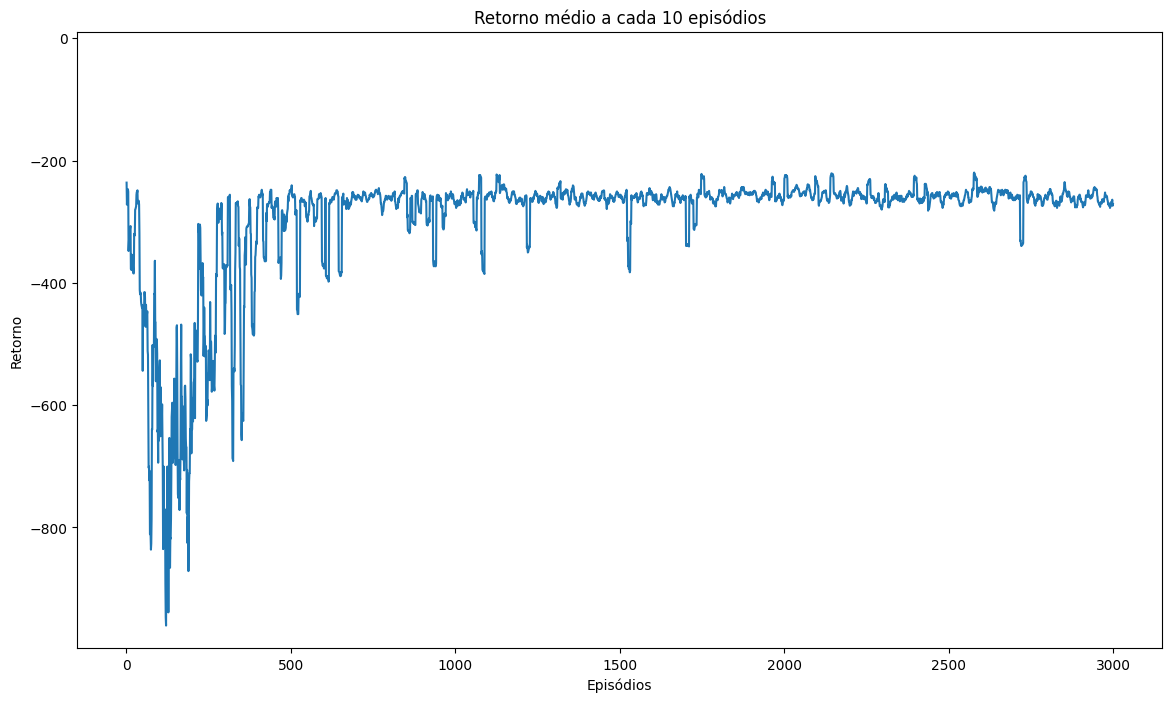

In [11]:
%timeit
ENV_NAME = "Taxi-v3"
#ENV_NAME = "Blackjack-v1"
r_max_plot = 10

EPISODES = 3000
GAMMA = 0.95
EPSILON = 0.1

env = gym.make(ENV_NAME)

# Roda o algoritmo Monte-Carlo para o problema de controle (ou seja, para achar a política ótima)
rewards, Qtable = run_montecarlo1(env, EPISODES, GAMMA, EPSILON, render=False)
print("Últimos resultados: media =", np.mean(rewards[-20:]), ", desvio padrao =", np.std(rewards[-20:]))

# Mostra um gráfico de episódios x retornos (não descontados)
# Se quiser salvar, passe o nome do arquivo no 3o parâmetro
filename = f"results/montecarlo1-{ENV_NAME.lower()[0:8]}-ep{EPISODES}.png"
plot_result(rewards, r_max_plot, None)

## 2 - Algoritmo (de Controle) de Monte Carlo - Versão 2

Modifique o código acima com essas características:
1. Mantenha o uso de `choose_action_1()` para escolher a ação.
1. Remova o **histórico** de retornos parciais.
1. Use uma **taxa de aprendizagem**, representada pelo parâmetro `lr`.

Faça as melhorias abaixo:

In [18]:
# Algoritmo Monte-Carlo de Controle, variante "toda-visita".
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_montecarlo2(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, render=False):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q toda com zero,
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-discontado)
    sum_rewards_per_ep = []

    # para cada episódio, guarda sua soma de recompensas (retorno não-discontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0
        ep_trajectory = []

        state = env.reset()

        # [1] Executa um episódio completo, salvando a trajetória
        while not done:
            # exibe/renderiza os passos no ambiente, durante 1 episódio a cada mil e também nos últimos 5 episódios
            if render and (i >= (episodes - 5) or (i+1) % 1000 == 0):
                env.render()

            # [2] Escolhe a próxima ação -- usa epsilon-greedy
            action = choose_action_1(Q, state, num_actions, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, done, _ = env.step(action)

            # adiciona a tripla que representa este passo
            ep_trajectory.append( (state, action, reward) )

            sum_rewards += reward
            state = next_state

        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if (i+1) % 100 == 0:
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

        # [3] Calcula os retornos parciais e atualiza Q
        Gt = 0
        for (s, a, r) in reversed(ep_trajectory):
            Gt = r + gamma*Gt

            # FAÇA AQUI A MODIFICAÇÂO PEDIDA !!!

    return sum_rewards_per_ep, Q

Quando o código estiver pronto, você poderá testar rodando o código abaixo:

In [ ]:
ENV_NAME = "Taxi-v3"
r_max_plot = 10

EPISODES = 20000
LR = 0.01
GAMMA = 0.95
EPSILON = 0.1

env = gym.make(ENV_NAME)

# Roda o algoritmo Monte-Carlo para o problema de controle (ou seja, para achar a política ótima)
rewards, Qtable = run_montecarlo2(env, EPISODES, LR, GAMMA, EPSILON, render=False)
print("Últimos resultados: media =", np.mean(rewards[-20:]), ", desvio padrao =", np.std(rewards[-20:]))

# Mostra um gráfico de episódios x retornos não descontados
# Se quiser salvar, passe o nome do arquivo no 3o parâmetro
#filename = f"results/montecarlo2-{ENV_NAME.lower()[0:8]}-ep{EPISODES}.png"
plot_result(rewards, r_max_plot, None)

## 3 - Algoritmo Q-Learning

Explicar um pouco aqui...

In [15]:
# Esta é a política. Neste caso, escolhe uma ação com base nos valores
# da tabela Q, usando uma estratégia epsilon-greedy.
def choose_action_2(Q, state, num_actions, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(0, num_actions)
    else:
        # melhoria: se houver empate, desempata aleatoriamente
        max_q = np.max(Q[state])
        return np.random.choice(np.where(Q[state] == max_q)[0])


# Algoritmo Q-learning, online learning (TD-learning)
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_qlearning(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, render=False):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com valores aleatórios de -1.0 a 0.0
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.random.uniform(low = -1.0, high = 0.0,
                          size = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-discontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state = env.reset()

        # executa um episódio completo, fazendo atualizações na Q-table
        while not done:
            # exibe/renderiza os passos no ambiente, durante 1 episódio a cada mil e também nos últimos 5 episódios
            if render and (i >= (episodes - 5) or (i+1) % 1000 == 0):
                env.render()

            # escolhe a próxima ação -- usa epsilon-greedy
            action = choose_action_2(Q, state, num_actions, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, done, _ = env.step(action)

            if done:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor máximo (melhor ação)
                V_next_state = np.max(Q[next_state])

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        #epsilon = np.exp(-0.005*i)

        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if (i+1) % 100 == 0:
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return sum_rewards_per_ep, Q

Agora, vamos testar o algoritmo:

Episode 100 Average Reward (last 100): -338.490
Episode 200 Average Reward (last 100): -282.030
Episode 300 Average Reward (last 100): -261.110
Episode 400 Average Reward (last 100): -238.070
Episode 500 Average Reward (last 100): -241.130
Episode 600 Average Reward (last 100): -243.390
Episode 700 Average Reward (last 100): -248.100
Episode 800 Average Reward (last 100): -231.650
Episode 900 Average Reward (last 100): -246.470
Episode 1000 Average Reward (last 100): -228.720
Episode 1100 Average Reward (last 100): -229.160
Episode 1200 Average Reward (last 100): -225.640
Episode 1300 Average Reward (last 100): -225.450
Episode 1400 Average Reward (last 100): -223.490
Episode 1500 Average Reward (last 100): -207.810
Episode 1600 Average Reward (last 100): -202.850
Episode 1700 Average Reward (last 100): -197.120
Episode 1800 Average Reward (last 100): -182.510
Episode 1900 Average Reward (last 100): -192.930
Episode 2000 Average Reward (last 100): -183.760
Episode 2100 Average Reward (

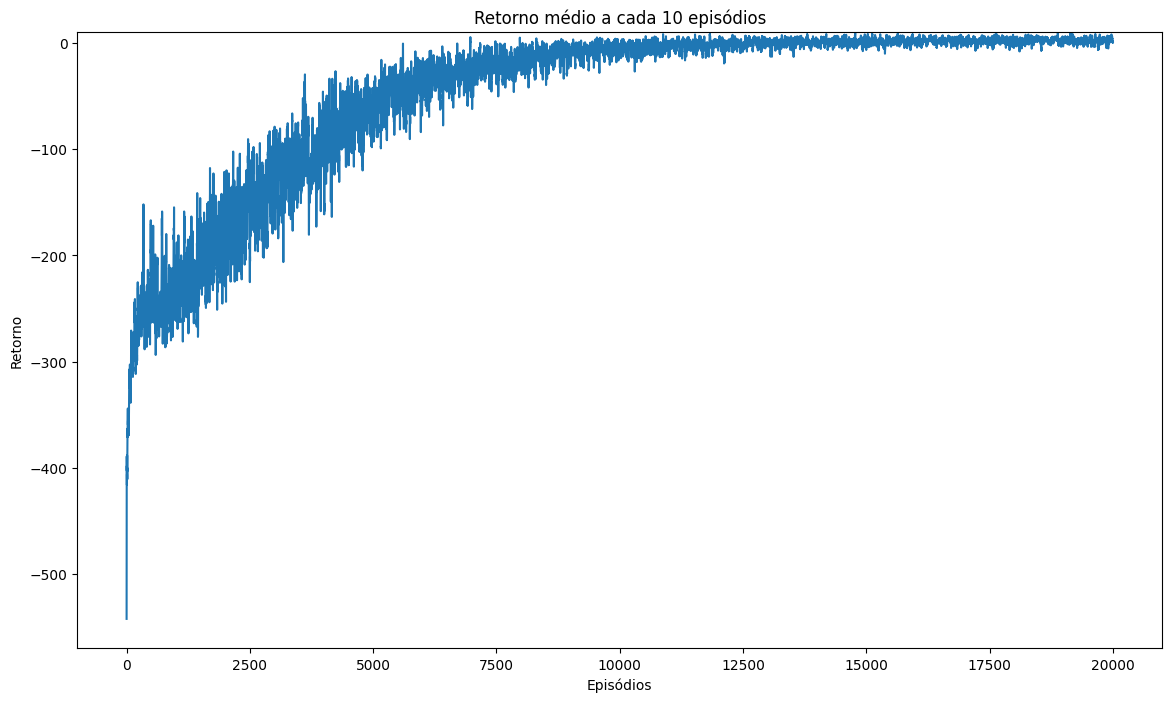

In [16]:
ENV_NAME = "Taxi-v3"
r_max_plot = 10

EPISODES = 20000
LR = 0.01
GAMMA = 0.95
EPSILON = 0.1

env = gym.make(ENV_NAME)

# Roda o algoritmo Q-Learning
rewards, Qtable = run_qlearning(env, EPISODES, LR, GAMMA, EPSILON, render=False)
print("Últimos resultados: media =", np.mean(rewards[-20:]), ", desvio padrao =", np.std(rewards[-20:]))

# Mostra um gráfico de episódios x retornos não descontados
# Se quiser salvar, passe o nome do arquivo no 3o parâmetro
#filename = f"results/qlearning-{ENV_NAME.lower()[0:8]}-ep{EPISODES}-lr{LR}.png"
plot_result(rewards, r_max_plot, None)

In [ ]:
test_greedy_Q_policy(env, Qtable, 10, False)

## 4 - Experimentos Finais


In [20]:
from util.experiments import repeated_exec
from util.plot import plot_multiple_results

Vamos comparar os algoritmos aqui propostos.

Executing <function run_montecarlo1 at 0x7fd0e1529000>:


  0%|          | 0/1 [00:00<?, ?it/s]

Episode 100 Average Reward (last 100): -427.610
Episode 200 Average Reward (last 100): -709.760
Episode 300 Average Reward (last 100): -480.980
Episode 400 Average Reward (last 100): -365.600
Episode 500 Average Reward (last 100): -290.630
Episode 600 Average Reward (last 100): -276.680
Episode 700 Average Reward (last 100): -272.900
Episode 800 Average Reward (last 100): -268.940
Episode 900 Average Reward (last 100): -263.810
Episode 1000 Average Reward (last 100): -258.410
Episode 1100 Average Reward (last 100): -260.750
Episode 1200 Average Reward (last 100): -263.900
Episode 1300 Average Reward (last 100): -259.490
Episode 1400 Average Reward (last 100): -268.400
Episode 1500 Average Reward (last 100): -258.680
Episode 1600 Average Reward (last 100): -259.940
Episode 1700 Average Reward (last 100): -258.410
Episode 1800 Average Reward (last 100): -266.600
Episode 1900 Average Reward (last 100): -275.600
Episode 2000 Average Reward (last 100): -259.130
Episode 2100 Average Reward (

100%|██████████| 1/1 [33:48<00:00, 2028.67s/it]


Episode 12000 Average Reward (last 100): -261.560
  (1 executions of Monte-Carlo1 finished in 2028.68 secs)
Executing <function run_qlearning at 0x7fd0e0b34280>:


  0%|          | 0/1 [00:00<?, ?it/s]

Episode 100 Average Reward (last 100): -317.530
Episode 200 Average Reward (last 100): -243.830
Episode 300 Average Reward (last 100): -226.930
Episode 400 Average Reward (last 100): -193.520
Episode 500 Average Reward (last 100): -184.450
Episode 600 Average Reward (last 100): -147.650
Episode 700 Average Reward (last 100): -133.310
Episode 800 Average Reward (last 100): -99.870
Episode 900 Average Reward (last 100): -97.020
Episode 1000 Average Reward (last 100): -70.030
Episode 1100 Average Reward (last 100): -62.040
Episode 1200 Average Reward (last 100): -45.320
Episode 1300 Average Reward (last 100): -39.810
Episode 1400 Average Reward (last 100): -33.680
Episode 1500 Average Reward (last 100): -28.750
Episode 1600 Average Reward (last 100): -20.270
Episode 1700 Average Reward (last 100): -18.680
Episode 1800 Average Reward (last 100): -12.920
Episode 1900 Average Reward (last 100): -7.590
Episode 2000 Average Reward (last 100): -5.460
Episode 2100 Average Reward (last 100): -7.3

100%|██████████| 1/1 [00:35<00:00, 35.74s/it]


Episode 11900 Average Reward (last 100): 2.930
Episode 12000 Average Reward (last 100): 3.650
  (1 executions of Q-Learning (LR=0.05) finished in 35.75 secs)
Executing <function run_qlearning at 0x7fd0e0b34280>:


  0%|          | 0/1 [00:00<?, ?it/s]

Episode 100 Average Reward (last 100): -325.990
Episode 200 Average Reward (last 100): -226.940
Episode 300 Average Reward (last 100): -187.090
Episode 400 Average Reward (last 100): -142.070
Episode 500 Average Reward (last 100): -94.120
Episode 600 Average Reward (last 100): -76.310
Episode 700 Average Reward (last 100): -38.520
Episode 800 Average Reward (last 100): -30.040
Episode 900 Average Reward (last 100): -20.530
Episode 1000 Average Reward (last 100): -12.660
Episode 1100 Average Reward (last 100): -8.010
Episode 1200 Average Reward (last 100): -6.100
Episode 1300 Average Reward (last 100): -2.680
Episode 1400 Average Reward (last 100): -0.260
Episode 1500 Average Reward (last 100): -0.850
Episode 1600 Average Reward (last 100): -0.850
Episode 1700 Average Reward (last 100): 0.080
Episode 1800 Average Reward (last 100): -0.160
Episode 1900 Average Reward (last 100): 1.680
Episode 2000 Average Reward (last 100): 2.700
Episode 2100 Average Reward (last 100): 1.740
Episode 2200

100%|██████████| 1/1 [00:29<00:00, 29.46s/it]


Episode 12000 Average Reward (last 100): 3.090
  (1 executions of Q-Learning (LR=0.1) finished in 29.47 secs)
Executing <function run_qlearning at 0x7fd0e0b34280>:


  0%|          | 0/1 [00:00<?, ?it/s]

Episode 100 Average Reward (last 100): -242.360
Episode 200 Average Reward (last 100): -74.890
Episode 300 Average Reward (last 100): -18.550
Episode 400 Average Reward (last 100): -5.600
Episode 500 Average Reward (last 100): -0.440
Episode 600 Average Reward (last 100): 0.400
Episode 700 Average Reward (last 100): 1.880
Episode 800 Average Reward (last 100): 2.630
Episode 900 Average Reward (last 100): 1.900
Episode 1000 Average Reward (last 100): 1.750
Episode 1100 Average Reward (last 100): 2.330
Episode 1200 Average Reward (last 100): 2.590
Episode 1300 Average Reward (last 100): 3.000
Episode 1400 Average Reward (last 100): 2.580
Episode 1500 Average Reward (last 100): 2.330
Episode 1600 Average Reward (last 100): 1.490
Episode 1700 Average Reward (last 100): 2.630
Episode 1800 Average Reward (last 100): 2.460
Episode 1900 Average Reward (last 100): 0.790
Episode 2000 Average Reward (last 100): 2.960
Episode 2100 Average Reward (last 100): 2.330
Episode 2200 Average Reward (last 

100%|██████████| 1/1 [00:22<00:00, 22.99s/it]


Episode 11900 Average Reward (last 100): 1.940
Episode 12000 Average Reward (last 100): 2.240
  (1 executions of Q-Learning (LR=0.5) finished in 23.01 secs)
Executing <function run_qlearning at 0x7fd0e0b34280>:


  0%|          | 0/1 [00:00<?, ?it/s]

Episode 100 Average Reward (last 100): -200.240
Episode 200 Average Reward (last 100): -39.660
Episode 300 Average Reward (last 100): -7.190
Episode 400 Average Reward (last 100): 0.570
Episode 500 Average Reward (last 100): 0.050
Episode 600 Average Reward (last 100): 1.270
Episode 700 Average Reward (last 100): 1.730
Episode 800 Average Reward (last 100): 1.040
Episode 900 Average Reward (last 100): 1.740
Episode 1000 Average Reward (last 100): 1.010
Episode 1100 Average Reward (last 100): 2.760
Episode 1200 Average Reward (last 100): 1.150
Episode 1300 Average Reward (last 100): 2.020
Episode 1400 Average Reward (last 100): 1.960
Episode 1500 Average Reward (last 100): 1.820
Episode 1600 Average Reward (last 100): 2.060
Episode 1700 Average Reward (last 100): 2.820
Episode 1800 Average Reward (last 100): 3.360
Episode 1900 Average Reward (last 100): 1.960
Episode 2000 Average Reward (last 100): 2.340
Episode 2100 Average Reward (last 100): 1.280
Episode 2200 Average Reward (last 100

100%|██████████| 1/1 [00:22<00:00, 22.72s/it]

Episode 11900 Average Reward (last 100): 2.170
Episode 12000 Average Reward (last 100): 1.320
  (1 executions of Q-Learning (LR=1.0) finished in 22.74 secs)


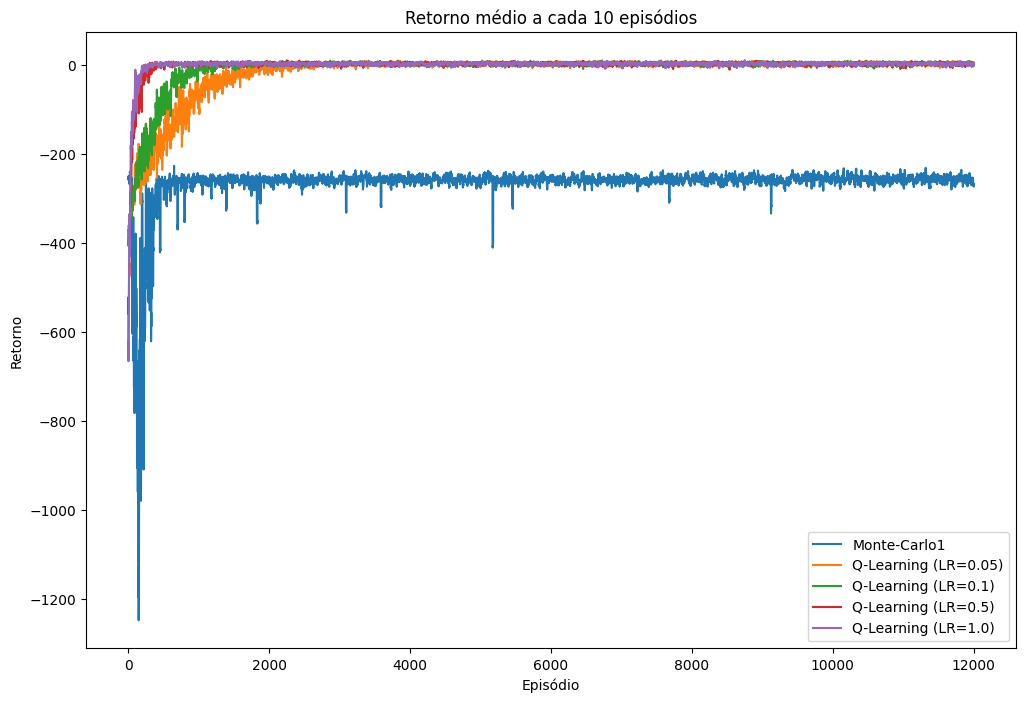

In [22]:
NUM_EPISODES = 12000

enviroment = gym.make("Taxi-v3")
#enviroment = gym.make("FrozenLake-v1")

results = []
# muito lento!
results.append( repeated_exec(1, "Monte-Carlo1", run_montecarlo1, enviroment, NUM_EPISODES) )

#for learning_rate in [0.01, 0.1, 0.5]:
#    results.append( repeated_exec(1, f"Monte-Carlo2 (LR={learning_rate})", run_montecarlo2, enviroment, NUM_EPISODES, learning_rate) )

for learning_rate in [0.05, 0.1, 0.5, 1.0]:
    results.append( repeated_exec(1, f"Q-Learning (LR={learning_rate})", run_qlearning, enviroment, NUM_EPISODES, learning_rate) )

clear_output()

plot_multiple_results(results, cumulative=False, x_log_scale=False)